# Uncertainty in drought indicators in the ERA5–Drought dataset

Production date: 2026-02-xx

**Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch.**

Dataset version: 1.0.

Produced by: Enis Gerxhalija, Olivier Burggraaff (National Physical Laboratory).

## 🌍 Use case: Use case listed here in full 

## ❓ Quality assessment question
* **In most cases there should be one question listed here in bold**
* **(In some cases a second related/follow-up question may be included)**

**‘Context paragraph’ (no title/heading)** - a very short introduction before the assessment statement describing approach taken to answer the user question. One or two key references could be useful,  if the assessment summarises literature . These can be referenced directly in the text, like `[Rodriguez et. al. 2018](https://doi.org/10.1038/s41598-018-20628-2)` giving: [Rodriguez et. al. 2018](https://doi.org/10.1038/s41598-018-20628-2). For major references numerical labels like this should be used (which should also listed at the end) `Rodriguez et. al. 2018, [[1]](https://doi.org/10.1038/s41598-018-20628-2))`giving: Rodriguez et. al. 2018, [[1]](https://doi.org/10.1038/s41598-018-20628-2)). Please use DOI links where possible.


## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* Finding 1
* Finding 2
* Finding 3
* etc
```

## 📋 Methodology

This quality assessment analyses the ensemble spread for SPI/SPEI drought indices retrieved from the [C3S ERA5-Drought dataset], as well as the reproducibility and usability of said dataset.

We will examine the SPI and SPEI drought indicator ensemble spread.

The analysis and results are organised in the following steps, which are detailed in the sections below:

**[](section-codesetup)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](section-spi)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

<!-- **[](section-spei)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](section-4)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.
 
**[](section-5)** 
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings. -->

Any further notes on the method could go here (explanations, caveats or limitations).

## 📈 Analysis and results

(section-codesetup)=
### 1. Code setup
```{note}
This notebook uses [earthkit](https://github.com/ecmwf/earthkit) for downloading ([earthkit-data](https://github.com/ecmwf/earthkit-data)) and visualising ([earthkit-plots](https://github.com/ecmwf/earthkit-plots)) data. Because earthkit is in active development, some functionality may change after this notebook is published. If any part of the code stops functioning, please raise an issue on our GitHub repository so it can be fixed.
```

#### Import required libraries
In this section, we import all the relevant packages needed for running the notebook.

In [1]:
# Input / Output
from pathlib import Path
import earthkit.data as ekd
import warnings

# General data handling
import numpy as np
import pandas as pd
import xarray as xr
from functools import partial

# Analysis
import calendar
from scipy import stats

# Visualisation
import earthkit.plots as ekp
from earthkit.plots.styles import Style
import matplotlib.pyplot as plt
plt.rcParams["grid.linestyle"] = "--"
from tqdm import tqdm  # Progress bars

# Visualisation in Jupyter book -- automatically ignored otherwise
try:
    from myst_nb import glue
except ImportError:
    glue = None

# Type hints
from typing import Callable, Iterable, Optional
from scipy.stats import rv_continuous as Distribution
from earthkit.plots.geo.domains import Domain
AnyDomain = (Domain | str)

#### Helper functions
This section defines some functions and variables used in the following analysis, allowing code cells in later sections to be shorter and ensuring consistency.

##### Data (pre-)processing

The following functions restructure the ensemble members in the ERA5-Drought dataset along a new dimension, as in ERA5:

In [2]:
def add_number_dimension(data: xr.Dataset, *, n_members: int=10,
                         time_dimension: str="time", ensemble_dimension: str="number") -> xr.Dataset:
    """
    Convert a dataset
    from ERA5-Drought format (10-duplicate `time` dimension)
    to ERA5 format (`number` dimension for ensemble members)
    """
    # Find unique times and use these to generate datasets for successive members
    member_numbers = np.arange(n_members)
    _, index = np.unique(data[time_dimension], return_index=True)
    data = [data.isel({time_dimension: index + i}) for i in member_numbers]

    # Combine into one dataset
    data = xr.concat(data, dim=ensemble_dimension).assign_coords(number=member_numbers)

    # Rechunk for memory efficiency
    data = data.chunk({ensemble_dimension: n_members, time_dimension: 48, "lat": 360, "lon": 103,})

    return data

##### Accumulation periods
The following cells contain constants and functions used in accumulating variables (e.g. precipitation) over time:

In [3]:
# Define constants such as the accumulation periods to use
ACCUMULATION_PERIODS = [1, 3, 6, 12, 24, 36, 48]  # Months
MONTHS = range(1, 13)  # January to December (inclusive)

##### Statistics
The following ...

In [4]:
def ensemble_mean_and_spread(data: xr.Dataset, *, number_dim: str="number") -> tuple[xr.Dataset, xr.Dataset]:
    """ Calculate the mean and spread within an ensemble along the number dimension. """
    # Calculate mean
    mean = data.mean(number_dim)

    # Calculate spread
    std = data.std(number_dim)
    divisor = np.sqrt(era5drought_ensemble_spi.sizes["number"] - 1)
    spread = std / divisor

    return mean, spread

##### Visualisation
The following cells contain functions for plotting results, starting with some base helper functions (e.g. displaying in Jupyter Notebook or Jupyter Book style, adding textboxes with consistent formatting, etc.):

In [5]:
_style_spi =        {"cmap": plt.cm.RdBu,    "vmin": -3, "vmax": 3,   "extend": "both"}
_style_spi_spread = {"cmap": plt.cm.cividis, "vmin": 0,  "vmax": 1.5, "extend": "max"}

styles = {
    "SPI_mean": Style(**_style_spi), "SPI_spread": Style(**_style_spi_spread),
}

# Apply general settings
for style in styles.values():
    style.normalize = False

In [6]:
def decorate_fig(fig: ekp.Figure, *, title: Optional[str]="") -> None:
    """ Decorate an earthkit figure with land, coastlines, etc. """
    # Add progress bar because individual steps can be very slow for large plots
    with tqdm(total=4, desc="Decorating", leave=False) as progressbar:
        fig.land()
        progressbar.update()
        fig.coastlines()
        progressbar.update()
        # fig.borders()
        # progressbar.update()
        fig.gridlines(linestyle=plt.rcParams["grid.linestyle"])
        progressbar.update()
        fig.title(title)
        progressbar.update()

The following cell contains functions for geospatial plots:

In [7]:
def geospatial_plot_mean_spread(data_mean: xr.Dataset, data_spread: xr.Dataset, indicator: str, date: str, *,
                                domain: Optional[AnyDomain]=None,
                                glue_label: Optional[str]=None) -> ekp.Figure:                   
    """
    Plot the mean and spread (pre-calculated) of an ensemble at a given time geospatially.
    """
    # Select data
    data_mean_spread = [data.sel({"time": date}) for data in (data_mean, data_spread)]

    # Determine if SPI or SPEI
    spi_or_spei = "SPEI" if "E" in indicator else "SPI"

    # Create figure
    fig = ekp.Figure(rows=1, columns=2, size=(8, 4))

    # Plot data
    for data, stat in zip(data_mean_spread, ["mean", "spread"]):
        # Plot data
        subplot = fig.add_map(domain=domain)
        subplot.grid_cells(data, z=indicator, style=styles[f"{spi_or_spei}_{stat}"])

        # Colour bar
        subplot.legend(location="bottom", label=f"{indicator} ({stat})")

    # Decorate figures
    decorate_fig(fig)
    fig.title(f"ERA5-Drought ensemble statistics on {date} in {domain}")
    
    # Show result
    plt.show()
    plt.close()

(section-spi)=
### 2. The ERA5-Drought ensemble: SPI

#### Download data 
Describe what is done in this step/section and what the `code` in the cell does(if code is included).

_In this assessment,
we will calculate SPI and SPEI for each month
(with different accumulation periods, see below)
for the years 1940–2024._
For the reference period,
we will use the World Meteorological Organization (WMO) current standard 30-year reference period of 1991–2020,
which is also used in ERA5-Drought.
Both of these date ranges can be adjusted in the cell below when running the analysis yourself:

In [8]:
# Define your preferred analysis and reference periods
years           = (1940, 2024)  # Years for the analysis (inclusive)
years_reference = (1991, 2020)  # Years for the reference period (inclusive)

Having defined our target years, we can now define our CDS request.
First, we define templates with some default parameters
(e.g. years, data format)
that will also be used later in the notebook.
Additional information for specific downloads
(e.g. variable, data stream)
is mixed into this template where relevant.

This notebook uses [earthkit-data](https://github.com/ecmwf/earthkit-data) to download files from the CDS.
If you intend to run this notebook multiple times, it is highly recommended that you [enable caching](https://earthkit-data.readthedocs.io/en/latest/guide/caching.html) to prevent having to download the same files multiple times.
If you prefer not to use earthkit, the following requests can also be used with the [cdsapi module](https://cds.climate.copernicus.eu/how-to-api#linux-use-client-step).
In either case (earthkit-data or cdsapi), it is required to set up a CDS account and API key as explained [on the CDS website](https://cds.climate.copernicus.eu/how-to-api).

In [9]:
ID_ERA5_DROUGHT = "derived-drought-historical-monthly"

# Main template
request_era5drought_template = {
    "version": "1_0",
    "dataset_type": "consolidated_dataset",
    "year": [f"{year}" for year in range(years[0], years[1]+1)],
    "month": [f"{month:02}" for month in MONTHS],
    "area": [-5, 109, -45, 159],
}

# Templates by product type (reanalysis / ensemble)
request_era5drought_reanalysis = {
    "product_type": ["reanalysis"],
} | request_era5drought_template

request_era5drought_ensemble = {
    "product_type": ["ensemble_members"],
} | request_era5drought_template

# Templates by variable (SPI / SPEI)
request_era5drought_spi = {
    "variable": ["standardised_precipitation_index"],
    "accumulation_period": ["12"],
}

request_era5drought_spei = {
    "variable": ["standardised_precipitation_evapotranspiration_index"],
    "accumulation_period": ["12"],
}

In [10]:
# Requests by variable (SPI / SPEI)
request_ensemble_spi = request_era5drought_spi | request_era5drought_ensemble

In [11]:
era5drought_ensemble_spi = ekd.from_source("cds", ID_ERA5_DROUGHT, request_ensemble_spi)
era5drought_ensemble_spi = era5drought_ensemble_spi.to_xarray(compat="equals") # Convert to xarray
era5drought_ensemble_spi  # Display

2026-02-08 13:14:13,389 WARNING [2025-10-30T00:00:00] Downloading data from this dataset requires that the user be registered with the CDS. The use of the API requires a CDS API key.
2026-02-08 13:14:13,391 INFO Request ID is c0a1f749-43f4-4ab6-a8ed-d3e3750bbfc8
2026-02-08 13:14:13,468 INFO status has been updated to accepted
2026-02-08 13:14:27,070 INFO status has been updated to running
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Max retries exceeded with url: /api/retrieve/v1/jobs/c0a1f749-43f4-4ab6-a8ed-d3e3750bbfc8?log=True&request=True (Caused by NameResolutionError("HTTPSConnection(host='cds.climate.copernicus.eu', port=443): Failed to resolve 'cds.climate.copernicus.eu' ([Errno -3] Temporary failure in name resolution)"))], attempt 1 of 500
Retrying in 120 seconds
2026-02-09 09:31:01,112 INFO status has been updated to successful


cc0518aa9fcbc43815c1671214b13bef.zip:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

  0%|          | 0/1009 [00:00<?, ?it/s]

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 10090, lat: 161, lon: 201)
Coordinates:
  * time     (time) datetime64[ns] 81kB 1940-12-01T06:00:00 ... 2024-12-01T06...
  * lat      (lat) float64 1kB -5.0 -5.25 -5.5 -5.75 ... -44.5 -44.75 -45.0
  * lon      (lon) float64 2kB 109.0 109.2 109.5 109.8 ... 158.5 158.8 159.0
Data variables:
    SPI12    (time, lat, lon) float64 3GB dask.array<chunksize=(1, 161, 201), meta=np.ndarray>
Attributes: (12/19)
    CDI:                     Climate Data Interface version 1.9.10 (https://m...
    Conventions:             CF-1.8
    source:                  DRYFALL v1.0
    institution:             European Centre for Medium-Range Weather Forecasts
    title:                   SPI12
    description:             Drought Index: Standardized Drought Index calcul...
    ...                      ...
    climate_end_date:        2020-12-31
    frequency:               Monthly
    contact_person:          support@ecmwf.int
    CDO:                     Climate Data Operators version 1.9.10 (https://m...
    ref_publication:         Keune, J., Di Giuseppe, F., Barnard, C., Damasio...
    cds_data_catalogue_url:  https://cds.climate.copernicus.eu/datasets/deriv...

Unlike ERA5, ERA5-Drought does not come with a `number` dimension representing the ensemble members.
Instead, they are accessible via the `time` dimension, which has 10 entries (representing the 10 members) at each point in time.
For convience, we re-organise the dataset to include a `number` dimension:

In [12]:
era5drought_ensemble_spi = add_number_dimension(era5drought_ensemble_spi)
era5drought_ensemble_spi

<xarray.Dataset> Size: 3GB
Dimensions:  (number: 10, time: 1009, lat: 161, lon: 201)
Coordinates:
  * number   (number) int64 80B 0 1 2 3 4 5 6 7 8 9
  * time     (time) datetime64[ns] 8kB 1940-12-01T06:00:00 ... 2024-12-01T06:...
  * lat      (lat) float64 1kB -5.0 -5.25 -5.5 -5.75 ... -44.5 -44.75 -45.0
  * lon      (lon) float64 2kB 109.0 109.2 109.5 109.8 ... 158.5 158.8 159.0
Data variables:
    SPI12    (number, time, lat, lon) float64 3GB dask.array<chunksize=(10, 48, 161, 103), meta=np.ndarray>
Attributes: (12/19)
    CDI:                     Climate Data Interface version 1.9.10 (https://m...
    Conventions:             CF-1.8
    source:                  DRYFALL v1.0
    institution:             European Centre for Medium-Range Weather Forecasts
    title:                   SPI12
    description:             Drought Index: Standardized Drought Index calcul...
    ...                      ...
    climate_end_date:        2020-12-31
    frequency:               Monthly
    contact_person:          support@ecmwf.int
    CDO:                     Climate Data Operators version 1.9.10 (https://m...
    ref_publication:         Keune, J., Di Giuseppe, F., Barnard, C., Damasio...
    cds_data_catalogue_url:  https://cds.climate.copernicus.eu/datasets/deriv...

In [13]:
era5drought_ensemble_spi_mean, era5drought_ensemble_spi_spread = ensemble_mean_and_spread(era5drought_ensemble_spi)

/home/eg6/c3s2-eqc-quality-assessment/.venv/lib/python3.12/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_map_units.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/eg6/c3s2-eqc-quality-assessment/.venv/lib/python3.12/site-packages/dask/array/numpy_compat.py:61: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
                                                                                                                    

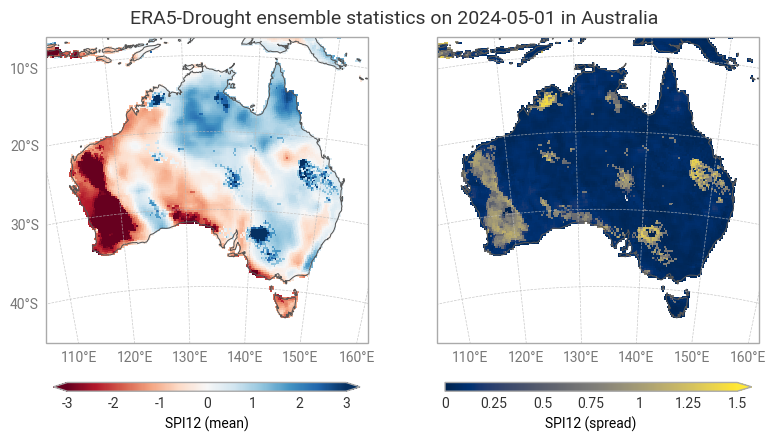

In [14]:
geospatial_plot_mean_spread(era5drought_ensemble_spi_mean, era5drought_ensemble_spi_spread, "SPI12", "2024-05-01",
                            domain="Australia")

Code under this cell needs to be adapted still.

#### SPI-12 time series in example site, w/ thresholds.

In [ ]:
da = drought_ens['SPI12']  # select the DataArray

plt.figure(figsize=(12, 6))

da.transpose('time', 'number').plot.line(x='time', hue='number', add_legend=True,
    figsize=(12, 5),
)
plt.hlines(y=[-1.5, 1.5], xmin=drought_ens_mean['time'].values.min(), xmax=drought_ens_mean['time'].values.max(), colors='r', linestyles='--', 
           label = "Thresholds")
# Customize plot
plt.title('SPI12 — Ensemble members over time')
plt.xlabel('Time')
plt.ylabel('SPI-12')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Plot ensemble mean & standard dev (one location, SPI-1) w/ Thresholds.

In [ ]:
drought_ens_mean = drought_ens.mean(dim="number")
drought_ens_std = drought_ens.std(dim="number")/np.sqrt(10-1)

plt.figure(figsize=(12, 6))

plt.plot(drought_ens_mean['time'].values, drought_ens_mean["SPI12"].values, label=f'SPI12')

# Two threshold lines
plt.hlines(y=[-1.5, 1.5],
           xmin=drought_ens_mean['time'].values.min(),
           xmax=drought_ens_mean['time'].values.max(),
           colors='r', linestyles='--', label='Extreme Wet/Dry Thresholds')

# Mean line
mean_spi12 = drought_ens_mean["SPI12"].mean().values
plt.hlines(y=mean_spi12,
           xmin=drought_ens_mean['time'].values.min(),
           xmax=drought_ens_mean['time'].values.max(),
           colors='b', linestyles='--', label='Mean SPI12 across time.')


plt.title('Ensemble mean of SPI12 vs Time')
plt.xlabel('Time')
plt.ylabel('SPI-12 Time Series')
plt.legend(title='12-month accumulation period')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Number of SPI greater than threshold value.

In [ ]:
da = drought_ens["SPI12"]  # dims: ('time',)

threshold_mag = 2

exceeds = np.abs(da) > threshold_mag # boolean xarray with all values that are "severely" wet/drier than usual.

count_per_time = exceeds.sum(dim='number') # count number that exceed along the ensemble dimension.

fractional_count_per_time = count_per_time / 10

percent_per_time = fractional_count_per_time*100

#### Plot of Mean, Stdev & P( > Severe Threshold ). 

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 8), sharex=True)

# --- Top panel: % members exceeding ---
percent_per_time.plot(ax=ax1, color='tab:purple')
ax1.set_title(f'% ensemble members with |SPI12| > {threshold_mag} per time')
ax1.set_ylabel('Percent (%)')
ax1.set_xlabel('Time')
ax1.grid(True)

# --- 2nd panel: Ensemble band ---
ci = drought_ens_std['SPI12'].values*np.sqrt(10-1) # confidence interval
y = drought_ens_mean['SPI12'].values
t = drought_ens_mean['time'].values

ax2.plot(t,y,label='SPI12 Mean', color='tab:blue')

# Horizontal thresholds ±2
ax2.hlines(y=[-threshold_mag, threshold_mag],
           xmin=drought_ens_mean['time'].values.min(),
           xmax=drought_ens_mean['time'].values.max(),
           colors='r', linestyles='--', label='Extreme Wet/Dry Thresholds')

ax2.set_title('Mean SPI12 vs Time')
ax2.set_xlabel('Time')
ax2.set_ylabel('Mean SPI-12')
ax2.legend(title='12-month accumulation period')
ax2.grid(True, alpha=0.3)


# --- 3nd panel: Ensemble band ---
ci = drought_ens_std['SPI12'].values*np.sqrt(10-1) # confidence interval
y = drought_ens_mean['SPI12'].values
t = drought_ens_mean['time'].values

# ax2.plot(t,y.values,label='SPI1 Mean', color='tab:blue')
ax3.fill_between(t, (y-ci), (y+ci), color='b')

# Horizontal thresholds ±1.5
ax3.hlines(y=[-threshold_mag, threshold_mag],
           xmin=drought_ens_mean['time'].values.min(),
           xmax=drought_ens_mean['time'].values.max(),
           colors='r', linestyles='--', label='Extreme Wet/Dry Thresholds')

ax3.set_title('Mean SPI12 vs Time with St.dev Band')
ax3.set_xlabel('Time')
ax3.set_ylabel('Mean SPI-12')
ax3.legend(title='12-month accumulation period')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Heat map of probability exceeding threshold

In [ ]:
import matplotlib.dates as mdates

t = percent_per_time['time'].values
y = percent_per_time.values

fig, ax = plt.subplots(figsize=(12, 2.8))

# Create a 2D array with one "row" so imshow can display it
heat = y[None, :]  # shape (1, T)

# Use extent to align x with datetime range
t_num = mdates.date2num(t)
extent = (t_num.min(), t_num.max(), 0, 1)

im = ax.imshow(
    heat,
    aspect='auto',
    cmap='RdBu_r',
    vmin=0, vmax=100,
    extent=extent
)

ax.set_yticks([])  # hide vertical axis (it's a strip)
ax.set_title('% ensemble members with |SPI12| > 1.5 (timeline color strip)')
ax.set_xlabel('Time')

# Ticks on time
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

cbar = plt.colorbar(im, ax=ax, pad=0.02)
cbar.set_label('Percent exceeding (%)')

plt.tight_layout()
plt.show()


#### Plot of |Mean(SPI)| > 1.5  & P( |SPI| > 1.5 ) > 0.5 

####  P( |SPI| > 1.5 )  calculated from # of ensemble members greater than threshold.

In [ ]:
da = drought_ens_mean["SPI12"]  # dims: ('time',)

probability_mag = 0.5 

cond_both = (np.abs(da > threshold_mag) & (fractional_count_per_time > probability_mag))

da_hit = da.sel(time=cond_both)

timestamps = da_hit.time.values

print(timestamps)

#### Histogram ensemble standard dev vs # quality flag (one location, one window)

In [ ]:
data = drought_ens_std["SPI12"]
sig = quality_spi_all["significance_12"]

thresholds = np.arange(0.1, 1.4, 0.1)  # 0.1 .. 1.5
bad_counts_cum = np.zeros_like(thresholds, dtype=int)
good_counts_cum = np.zeros_like(thresholds, dtype=int)

for month in range(1,13):
        significance = quality_spi_all[f"significance_1"].sel(time=f"2020-{month:02d}-01").compute().item()
        if significance == 0:
            vals = data.where(data.time.dt.month == month, drop=True).values
            bad_counts_cum += (vals[:, None] < thresholds[None, :]).sum(axis=0) # then sum along column.
            # bad_counts_cum[j] = number of vals that are < thresholds[j]
            # B[i, j] = (vals[i] < thresholds[j])
        else:
            vals = data.where(data.time.dt.month == month, drop=True).values
            good_counts_cum += (vals[:, None] < thresholds[None, :]).sum(axis=0)

In [ ]:
bad_bins  = np.diff(np.concatenate(([0], bad_counts_cum)))
good_bins = np.diff(np.concatenate(([0], good_counts_cum)))
total_bins = bad_bins + good_bins
good_norm = good_bins / total_bins
bad_norm = bad_bins / total_bins

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(thresholds, good_norm, width = 0.1, color='blue', alpha=0.8, label='Quality = 1 (good)')
ax.bar(thresholds, bad_norm, width = 0.1,  color='red', bottom = good_norm, alpha=0.9, label='Quality = 0 (bad)')

ax.set_xlabel('Uncertainty in SPI1 (0.1 bin)')
ax.set_ylabel('% count of good/bad months (stacked)')
ax.set_title('% counts (stacked) for each uncertainty bin')
ax.set_xticks(thresholds)
ax.set_xticklabels([f'{t:.1f}' for t in thresholds])
ax.grid(True, linestyle='--', alpha=0.35)
ax.legend()
plt.tight_layout()
plt.show()



#### Reading in ERA5 SPI- Ensemble (global, 2 years)

In [ ]:
dataset = "derived-drought-historical-monthly"
request = {
    "variable": ["standardised_precipitation_index"],
    "accumulation_period": ["48"],
    "version": "1_0",
    "product_type": ["ensemble_members"],
    "dataset_type": "consolidated_dataset",
    "year": [
        "2023",
        "2024"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
}

In [ ]:
data_drought_ens = ekd.from_source("cds", dataset, request) # Sends request for this dataset to CDS.
data_drought_ens = data_drought_ens.to_xarray(compat="equals") # Converts to xarray.

#### Function to create the data into ensemble set.

In [ ]:
# Function to reshape time into (time=24, ensemble=10)
def make_ensemble(spi):
    arr = np.asarray(spi)  # Convert memoryview or dask chunk to NumPy
    reshaped = arr.reshape(24, 10)
    return reshaped
 
# Apply across all lat/lon
ensemble = xr.apply_ufunc(
    make_ensemble,
    data_drought_ens["SPI48"],  # DataArray with dims (time, lat, lon)
    input_core_dims=[["time"]],
    output_core_dims=[["time", "ensemble"]],
    exclude_dims={"time"},
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float],
    dask_gufunc_kwargs={"allow_rechunk": True},
    output_sizes={"time": 24, "ensemble": 10},
)
 
# Assign coordinates
ensemble = ensemble.assign_coords({
    "time": pd.date_range("2023-01-01", periods=24, freq="MS"),
    "ensemble": range(1, 11)
})
ensemble.name = "SPI48"

#### Selecting ensemble member 1.

In [ ]:
ensemble = ensemble.sel(ensemble=1)

In [ ]:
spi_values = ensemble.compute()

#### Calculating mean and stdev over all ensemble members.

In [ ]:
ensemble_mean = ensemble.mean(dim="ensemble", skipna=True)  # shape: (lat, lon, time)
ensemble_std = ensemble.std(dim="ensemble", skipna=True)  # shape: (lat, lon, time)

In [ ]:
ensemble_mean_time = abs(ensemble_mean).mean(dim="time", skipna=True)  # shape: (lat, lon, time)
ensemble_std_time = ensemble_std.std(dim="time", skipna=True)  # shape: (lat, lon, time)

In [ ]:
ensemble_std = ensemble_std.compute()  # Load into memory for plotting
ensemble_std_time = ensemble_std_time.compute() 

ensemble_mean = ensemble_mean.compute()  # Load into memory for plotting
ensemble_mean_time = ensemble_mean_time.compute()

#### Plot of mean vs stdev over all ensemble members.

In [ ]:
# Select one time slice and one ensemble
from earthkit.plots.styles import Style

global_std_map = ensemble_std.sel(time="2024-05-01")  # shape (lat, lon)
global_mean_map = ensemble_mean.sel(time="2024-05-01")

# global_std_map = ensemble_std_time
# global_mean_map = ensemble_mean_time

# Convert to NumPy arrays

std_values = global_std_map.to_numpy()/np.sqrt(10)
mean_values = global_mean_map.to_numpy()

lat_values = global_mean_map.lat.to_numpy()
lon_values = global_mean_map.lon.to_numpy()
 
# Create meshgrid

lon_grid, lat_grid = np.meshgrid(lon_values, lat_values)
 
# # Plot with EarthKit

SPI_STYLE = Style(cmap='RdBu', vmin = -3, vmax = 3, normalize=False)
SPI_SEOM_STYLE = Style(cmap='cividis', vmin = 0, vmax = 0.5, normalize=False) # _r for reversing colorbar.

# Create figure with 2 columns
fig = ekp.Figure(rows=1, columns=2, size=(12, 6))  # <-- Important!

# First subplot (left)
subplot = fig.add_map(domain="Australia", row=0, column=0)
subplot.grid_cells(mean_values, x=lon_grid, y=lat_grid,style=SPI_STYLE)
subplot.legend(location="right")

# Second subplot (right)
subplot1 = fig.add_map(domain="Australia", row=0, column=1)
subplot1.grid_cells(std_values, x=lon_grid, y=lat_grid, style = SPI_SEOM_STYLE)
subplot1.legend(location="right")

subplot.title("Mean | SPI | ")
subplot1.title("SPI SEOM")

# Add decorations
fig.title("SPI Ensemble (N=10) averaged across 2023-2024 month, 1 month accumulation period.")
fig.land()
fig.coastlines()
fig.borders()
fig.gridlines()
fig.show()


#### Plot of P( |SPI48| >= 2 ) over entire region, for one time.

In [ ]:
da = ensemble  # dims: ('time',)

threshold_mag = 2

exceeds = np.abs(da) >= threshold_mag # boolean xarray with all values that are "severely" wet/drier than usual.

count_per_time = exceeds.sum(dim='ensemble') # count number that exceed along the ensemble dimension.

fractional_count_per_time = count_per_time / 10

percent_per_time = fractional_count_per_time*100

In [ ]:

from matplotlib.colors import ListedColormap
from earthkit.plots.styles import Style

# --- Define mask FIRST ---
extreme_mask = (mean_values >= 2) | (mean_values <= -2)

# Build a constant-valued mask for the grey layer:
# 1 where non-extreme (|SPI| ≤ 2), NaN where extreme (so extremes won't be drawn in grey)
nonextreme_const = np.where(~extreme_mask, 1.0, np.nan)

# For the colored overlay, keep only extreme values (NaN elsewhere)
mean_extremes = np.where(extreme_mask, mean_values, np.nan)

# --- Styles ---
# Single-colour style for non-extremes: ensure a tight 0–1 range
GREY_STYLE = Style(
    cmap=ListedColormap(["#d9d9d9"]),
    vmin=0, vmax=1,
    normalize=False
)

# SPI style for extremes; use a symmetric range that suits your data
SPI_STYLE = Style(
    cmap='RdBu',
    vmin=-4, vmax=4,    # adjust to your expected SPI range
    normalize=False
)

# --- Plot ---
fig = ekp.Figure(rows=1, columns=2, size=(12, 6))

# Left subplot: mean SPI48 with grey background for non-extremes
subplot = fig.add_map(domain="Australia", row=0, column=0)

# Draw grey background first
subplot.grid_cells(
    nonextreme_const, x=lon_grid, y=lat_grid,
    style=GREY_STYLE, zorder=1, alpha=0.8  # alpha to ensure visibility
)

# Overlay extremes with color
subplot.grid_cells(
    mean_extremes, x=lon_grid, y=lat_grid,
    style=SPI_STYLE, zorder=2
)

subplot.legend(location="right")


subplot.title("|Mean SPI48| ≥ 2 | (grey = |Mean SPI| ≤ 2)")

longitude = [142]
latitude = [-29.25]

# Plot the point as a scatter plot
subplot.scatter(x=longitude, y=latitude, color='red', marker='o', s=100, label = "Tibooburra")

# Right subplot (unchanged example)
SPI_SEOM_STYLE = Style(cmap='cividis', normalize=False)
subplot1 = fig.add_map(domain="Australia", row=0, column=1)
subplot1.grid_cells(percent_values, x=lon_grid, y=lat_grid, style=SPI_SEOM_STYLE)
subplot1.legend(location="right")
subplot1.title("P(| SPI48 | > 2)")
subplot1.scatter(x=longitude, y=latitude, color='red', marker='o', s=100, label = "Tibooburra")

fig.title("SPI48 Ensemble (N=10) with Tibooburra pointed out.")
fig.land(); fig.coastlines(); fig.borders(); fig.gridlines()
fig.show()



#### Analysing uncertainty correlation.

In [ ]:
spi_mean = ensemble_mean_time
spi_seom = ensemble_std_time / np.sqrt(10)

spi_mean = np.where((np.abs(spi_mean) <= 3) , spi_mean, np.nan)
spi_seom = np.where((np.abs(spi_mean) <= 3), spi_seom, np.nan)

# Flatten & mask
x = spi_mean.ravel()          # SPI mean
y = spi_seom.ravel()   # SPI standard uncertainty (N=10)
mask = np.isfinite(x) & np.isfinite(y)
x = x[mask]; y = y[mask]

In [ ]:
# Plot
plt.figure(figsize=(8, 6), dpi=160)
plt.scatter(x, y, s=8, alpha=0.5, color="#1f77b4", edgecolors="none")
plt.xlabel("Mean | SPI-1 |")
plt.ylabel("SPI-1 Standard Uncertainty of the mean (N=10)")
plt.title("Mean | SPI-1 | vs SPI-1 SUOM for SPI <= 3 across 2023-2024")
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

In [ ]:

# Masks (ignore NaNs in x or y)
mask_neg = (x < 0) & np.isfinite(x) & np.isfinite(y)
mask_pos = (x >= 0) & np.isfinite(x) & np.isfinite(y)

n_neg = np.count_nonzero(mask_neg)
n_pos = np.count_nonzero(mask_pos)

# Compute means; if group empty, set to None
mean_y_neg = float(np.nanmean(y[mask_neg])) if n_neg > 0 else None
mean_y_pos = float(np.nanmean(y[mask_pos])) if n_pos > 0 else None

# Helper for formatting
def fmt_mean(m):
    return f"{m:.4f}" if m is not None and np.isfinite(m) else "NA"

print("Group summaries:")
print(f"  x < 0    -> n = {n_neg:4d}, mean(y) = {fmt_mean(mean_y_neg)}")
print(f"  x >= 0   -> n = {n_pos:4d}, mean(y) = {fmt_mean(mean_y_pos)}")


In [ ]:
# --- your scatter (unchanged) ---
# Assign colors based on sign of x
colors = np.where(x < 0, 'red', 'blue')

plt.figure(figsize=(8, 6), dpi=160)
plt.scatter(
    x, y,
    s=8,
    alpha=0.5,
    color=colors,
    edgecolors='none'
)

plt.xlabel("Mean SPI-1")
plt.ylabel("SPI-1 Standard Uncertainty of the mean (N=10)")
plt.title("Mean SPI-1 vs SPI-1 SUOM for SPI <= 3 across 2023-2024")
plt.grid(True, alpha=0.25)
plt.tight_layout()

# --- compute means (ignore NaNs in x or y) ---
mask_neg = (x < 0) & np.isfinite(x) & np.isfinite(y)
mask_pos = (x >= 0) & np.isfinite(x) & np.isfinite(y)

n_neg = int(np.count_nonzero(mask_neg))
n_pos = int(np.count_nonzero(mask_pos))

mean_y_neg = float(np.nanmean(y[mask_neg])) if n_neg > 0 else None
mean_y_pos = float(np.nanmean(y[mask_pos])) if n_pos > 0 else None

def fmt_mean(m):
    return f"{m:.4f}" if (m is not None and np.isfinite(m)) else "NA"

# --- print on the plot as text boxes ---
ax = plt.gca()

# Left text box (x < 0)
left_text = f"SPI-1 < 0:\n  n = {n_neg}\n  mean(SPI SUOM) = {fmt_mean(mean_y_neg)}"
ax.text(
    0.02, 0.98, left_text,
    transform=ax.transAxes,
    va='top', ha='left',
    color='red',
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='red', alpha=0.9, boxstyle='round,pad=0.3')
)

# Right text box (x >= 0)
right_text = f"SPI-1 >= 0:\n  n = {n_pos}\n  mean(SPI SUOM) = {fmt_mean(mean_y_pos)}"
ax.text(
    0.98, 0.98, right_text,
    transform=ax.transAxes,
    va='top', ha='right',
    color='blue',
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='blue', alpha=0.9, boxstyle='round,pad=0.3')
)

# Optional: vertical reference line at x = 0
ax.axvline(0, color='k', linestyle=':', linewidth=1.2, alpha=0.7)

plt.show()

#### Plot of mean ensemble Standard Uncertainty of the Mean vs Time (Australia)

In [ ]:

# -----------------------
# 1) Global mean time series
# -----------------------
# Simple average over lat/lon for each time
global_ts = ensemble_std.mean(dim=("lat", "lon"), skipna=True)
global_ts.name = "global_mean_std"

# -----------------------
# 2) Australia domain mean time series
# -----------------------
# Define a rectangular box that covers mainland Australia
# Adjust if you want to include territories or use a different extent.
AU_LAT_MIN, AU_LAT_MAX = -45.0, -5.0
AU_LON_MIN, AU_LON_MAX = 100.0, 160.0

# If your longitude coordinate is 0..360, these bounds already work.
# If it's -180..180, they also work (Australia is at positive longitudes).

lat_sel = (ensemble_std["lat"] >= AU_LAT_MIN) & (ensemble_std["lat"] <= AU_LAT_MAX)
lon_sel = (ensemble_std["lon"] >= AU_LON_MIN) & (ensemble_std["lon"] <= AU_LON_MAX)

ensemble_std_au = ensemble_std.where(lat_sel & lon_sel, drop=True)
aus_ts = ensemble_std_au.mean(dim=("lat", "lon"), skipna=True)
aus_ts.name = "australia_mean_std"

# -----------------------
# 3) Plot
# -----------------------
plt.figure(figsize=(10, 5), dpi=140)
plt.plot(global_ts["time"], global_ts, label="Global mean std", lw=1.8)
plt.plot(aus_ts["time"], aus_ts, label="Australia mean std", lw=1.8)
plt.title("Mean Ensemble Standard Deviation — Global vs Australia (unweighted)")
plt.xlabel("Time")
plt.ylabel("Standard deviation")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
pltplt.show()

# -----------------------
# 4) Optional: Export as DataFrame
# -----------------------
df = xr.merge([global_ts, aus_ts]).to_dataframe()


(section-5)=
### 5. Applying the Ensemble Data

#### Results Subsections

#### Importing in GH Precipitation Station locations.

In [ ]:
from urllib.request import urlopen
import io

# --- Helper to download text ---
def read_text(primary_url: str, fallback_url: str = None, *, timeout: int = 30) -> str:
    last_err = None
    for url in [primary_url, fallback_url]:
        if not url:
            continue
        try:
            with urlopen(url, timeout=timeout) as r:
                return r.read().decode("utf-8", errors="ignore")
        except Exception as e:
            last_err = e
    raise RuntimeError(f"Failed to download text from provided URLs. Last error: {last_err}")

# --- Configuration ---
DOMAIN = "Australia"
GRID_DEG = 0.25
USE_LOCAL = False
LOCAL_STATIONS = "./ghcnd-stations.txt"
LOCAL_INVENTORY = "./ghcnd-inventory.txt"

NCEI_STATIONS_URL  = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt"
NCEI_INVENTORY_URL = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-inventory.txt"
AWS_STATIONS_URL   = "https://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-stations.txt"
AWS_INVENTORY_URL  = "https://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-inventory.txt"

ACTIVE_YEAR = 2024  # <-- only keep stations operating in this year

# --- SPI grid you've prepared earlier ---
global_std_map  = ensemble_std_time  # (lat, lon)
lat_values      = global_std_map.lat.to_numpy()
lon_values      = global_std_map.lon.to_numpy()
std_values      = global_std_map.to_numpy() / np.sqrt(10)
lon_grid, lat_grid = np.meshgrid(lon_values, lat_values)

# --- Helpers ---
def to_year(s):
    """Extract a 4-digit year from inventory 'first'/'last' fields."""
    if s is None:
        return np.nan
    s = str(s).strip()
    digits = ''.join(c for c in s if c.isdigit())
    return int(digits[:4]) if len(digits) >= 4 else np.nan

# --- 1) Read GHCNd station & inventory text files ---
if USE_LOCAL and Path(LOCAL_STATIONS).exists():
    stations_text = Path(LOCAL_STATIONS).read_text(encoding="utf-8", errors="ignore")
else:
    stations_text = read_text(NCEI_STATIONS_URL, AWS_STATIONS_URL)

if USE_LOCAL and Path(LOCAL_INVENTORY).exists():
    inventory_text = Path(LOCAL_INVENTORY).read_text(encoding="utf-8", errors="ignore")
else:
    inventory_text = read_text(NCEI_INVENTORY_URL, AWS_INVENTORY_URL)

# Parse station metadata: ID, lat, lon
stations_df = pd.read_csv(
    io.StringIO(stations_text),
    sep=r"\s+",
    header=None,
    usecols=[0, 1, 2],
    names=["station_id", "lat", "lon"],
    dtype={"station_id": str, "lat": float, "lon": float},
    engine="python"
)

# Parse inventory: id, lat, lon, element, first, last
inv_df = pd.read_csv(
    io.StringIO(inventory_text),
    sep=r"\s+",
    header=None,
    names=["station_id", "lat_inv", "lon_inv", "element", "first", "last"],
    dtype={"station_id": str, "lat_inv": float, "lon_inv": float, "element": str, "first": str, "last": str},
    engine="python"
)

# Keep PRCP entries and compute begin/end years
inv_prcp = inv_df[inv_df["element"] == "PRCP"].copy()
inv_prcp["first_year"] = inv_prcp["first"].apply(to_year)
inv_prcp["last_year"]  = inv_prcp["last"].apply(to_year)

# --- Filter: stations operating during ACTIVE_YEAR ---
inv_prcp_active = inv_prcp[
    (inv_prcp["first_year"] <= ACTIVE_YEAR) & (inv_prcp["last_year"] >= ACTIVE_YEAR)
].copy()

# Deduplicate station IDs and merge coordinates from stations file
prcp_stations_active = (
    inv_prcp_active[["station_id"]]
    .drop_duplicates()
    .merge(stations_df, on="station_id", how="left")
    .dropna(subset=["lat", "lon"])
    .reset_index(drop=True)
)

print(f"# Active PRCP stations (operating in {ACTIVE_YEAR}): {len(prcp_stations_active)}")

# --- 2) Bin active PRCP stations onto a 0.25° grid ---
lat_edges = np.arange(-90.0,  90.0 + GRID_DEG, GRID_DEG)
lon_edges = np.arange(-180.0, 180.0 + GRID_DEG, GRID_DEG)
H, _, _ = np.histogram2d(
    prcp_stations_active["lat"].values,
    prcp_stations_active["lon"].values,
    bins=[lat_edges, lon_edges]
)

lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2
lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2
counts_da = xr.DataArray(H, coords={"lat": lat_centers, "lon": lon_centers}, dims=("lat", "lon"))

# Interpolate counts to your SPI grid (nearest keeps integer counts)
counts_on_spi = counts_da.interp(lat=lat_values, lon=lon_values, method="nearest")
gauge_values  = counts_on_spi.to_numpy()

# --- 3) Styles ---
vmax_est = max(10, float(np.nanpercentile(gauge_values, 99)))
GAUGE_STYLE    = Style(cmap="cividis", vmin=0, vmax=vmax_est, normalize=False)
SPI_SEOM_STYLE = Style(cmap="cividis", normalize=False)

# --- 4) EarthKit figure (side-by-side) ---
fig = ekp.Figure(rows=1, columns=2, size=(12, 6))

# LEFT: active PRCP station counts
subplot_left = fig.add_map(domain=DOMAIN, row=0, column=0)
subplot_left.grid_cells(gauge_values, x=lon_grid, y=lat_grid, style=GAUGE_STYLE)
subplot_left.legend(location="right")
subplot_left.title(f"GHCNd PRCP stations active in {ACTIVE_YEAR} per 0.25° cell")

# RIGHT: SPI standard uncertainty (N=10)
subplot_right = fig.add_map(domain=DOMAIN, row=0, column=1)
subplot_right.grid_cells(std_values, x=lon_grid, y=lat_grid, style=SPI_SEOM_STYLE)
subplot_right.legend(location="right")
subplot_right.title("Mean SPI Standard Uncertainty across 2023–2024 (N=10)")

fig.land(); fig.coastlines(); fig.borders(); fig.gridlines()



In [ ]:
import re 
from urllib.request import urlopen

# --- Configuration ---
USE_LOCAL = False
LOCAL_STATIONS  = "./ghcnd-stations.txt"
LOCAL_INVENTORY = "./ghcnd-inventory.txt"

# Official NOAA endpoints (AWS mirror fallback)
NCEI_STATIONS_URL  = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt"
NCEI_INVENTORY_URL = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-inventory.txt"
AWS_STATIONS_URL   = "https://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-stations.txt"
AWS_INVENTORY_URL  = "https://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-inventory.txt"

# Domain selection
USE_COUNTRY_CODES = True  # default: filter by GHCN country codes
AU_CODES = ("AS", "CK", "KT", "NF")  # Australia + territories (per GHCN countries list)

def to_year(s):
    """Extract 4-digit year from 'YYYY' or 'YYYYMMDD' strings; return np.nan if not parseable."""
    if s is None:
        return np.nan
    s = str(s).strip()
    digits = re.sub(r"[^0-9]", "", s)
    return int(digits[:4]) if len(digits) >= 4 else np.nan

# --- 1) Load stations & inventory (GHCN-Daily) ---
if USE_LOCAL and Path(LOCAL_STATIONS).exists():
    stations_text = Path(LOCAL_STATIONS).read_text(encoding="utf-8", errors="ignore")
else:
    stations_text = read_text(NCEI_STATIONS_URL, AWS_STATIONS_URL)

if USE_LOCAL and Path(LOCAL_INVENTORY).exists():
    inventory_text = Path(LOCAL_INVENTORY).read_text(encoding="utf-8", errors="ignore")
else:
    inventory_text = read_text(NCEI_INVENTORY_URL, AWS_INVENTORY_URL)

# Stations file (metadata; we’ll use ID+coords for country-code filter cross-check if desired)
stations_df = pd.read_csv(
    io.StringIO(stations_text),
    sep=r"\s+",
    header=None,
    usecols=[0, 1, 2],
    names=["station_id", "lat", "lon"],
    dtype={"station_id": str, "lat": float, "lon": float},
    engine="python",
)

# Inventory: id, lat, lon, element, first, last (period-of-record per element)
inv_df = pd.read_csv(
    io.StringIO(inventory_text),
    sep=r"\s+",
    header=None,
    names=["station_id", "lat_inv", "lon_inv", "element", "first", "last"],
    dtype={"station_id": str, "lat_inv": float, "lon_inv": float, "element": str, "first": str, "last": str},
    engine="python",
)

# Keep PRCP entries and derive begin/end years
inv_prcp = inv_df[inv_df["element"] == "PRCP"].copy()
inv_prcp["first_year"] = inv_prcp["first"].apply(to_year)
inv_prcp["last_year"]  = inv_prcp["last"].apply(to_year)

# Drop any rows with invalid years or inverted ranges
inv_prcp = inv_prcp[np.isfinite(inv_prcp["first_year"]) & np.isfinite(inv_prcp["last_year"])]
inv_prcp = inv_prcp[inv_prcp["last_year"] >= inv_prcp["first_year"]].copy()

# Optional geographic bounding box (set to True to use instead of country codes)
USE_BBOX = False
AU_BBOX = dict(lat_min=-45, lat_max=-5, lon_min=100, lon_max=160)

# --- Helpers ---
# --- 2) Domain filter (Australia) ---
if USE_COUNTRY_CODES:
    # Filter by GHCN ID prefix: first two letters denote FIPS country code (e.g., 'AS' for Australia)
    # Also include Australian territories: CK (Cocos-Keeling), KT (Christmas Island), NF (Norfolk Island).
    mask_cc = inv_prcp["station_id"].str.slice(0, 2).isin(AU_CODES)
    au_prcp = inv_prcp[mask_cc].copy()
else:
    au_prcp = inv_prcp.copy()

if USE_BBOX:
    # Spatial clip (lat/lon from inventory)
    m = (
        (au_prcp["lat_inv"] >= AU_BBOX["lat_min"]) & (au_prcp["lat_inv"] <= AU_BBOX["lat_max"]) &
        (au_prcp["lon_inv"] >= AU_BBOX["lon_min"]) & (au_prcp["lon_inv"] <= AU_BBOX["lon_max"])
    )
    au_prcp = au_prcp[m].copy()

# --- 3) Count active stations per year ---
if au_prcp.empty:
    raise ValueError("No PRCP stations found for the Australia domain with the chosen filter.")

year_min = int(au_prcp["first_year"].min())
year_max = int(au_prcp["last_year"].max())
years = np.arange(year_min, year_max + 1)

# Vectorized counting:
# For each station: active in year Y if first_year <= Y <= last_year
firsts = au_prcp["first_year"].to_numpy()
lasts  = au_prcp["last_year"].to_numpy()

counts = []
for y in years:
    counts.append(np.sum((firsts <= y) & (lasts >= y)))
counts = np.array(counts, dtype=int)

# --- 4) Plot ---
plt.figure(figsize=(10, 5), dpi=160)
plt.plot(years, counts, color="#1f77b4", lw=1.8)
plt.title("Active GHCNd PRCP Stations per Year — Australia domain")
plt.xlabel("Year")
plt.ylabel("Number of active stations")
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()



#### Elevation vs SPI uncertainty.

In [ ]:
dataset = "reanalysis-era5-land"
request = {
    "variable": ["geopotential"],
    "data_format": "netcdf",
    "download_format": "unarchived"
}

geo_pot = ekd.from_source("cds", dataset, request) # Sends request for this dataset to CDS.
geo_pot = geo_pot.to_xarray() # Converts to xarray.


In [ ]:
SPI_SEOM_STYLE = Style(cmap="cividis", vmin=0, vmax=0.5, normalize=False) # _r for reversing colorbar.

RB_STYLE = Style(cmap="cividis", normalize=False)  # let data drive the range

geo_pot["h"] = geo_pot["z"]/9.81

global_map = geo_pot["h"] 

global_map.name = "height"
fig = ekp.Figure(rows=1, columns=1, size=(8, 6))

global_map.attrs["units"] = "m"
global_map.attrs["long_name"] = "Height above sea level"

# Convert to NumPy arrays
global_std_map = ensemble_std_time
std_values = global_std_map.to_numpy()/np.sqrt(10)
lat_values = global_std_map.lat.to_numpy()
lon_values = global_std_map.lon.to_numpy()
 
# Create meshgrid

lon_grid, lat_grid = np.meshgrid(lon_values, lat_values)
 
# # Plot with EarthKit

# Create figure with 2 columns
fig = ekp.Figure(rows=1, columns=2, size=(12, 6))  # <-- Important!

# First subplot (left)
subplot = fig.add_map(domain="Australia", row=0, column=0)
subplot.grid_cells(global_map, style= RB_STYLE)
subplot.legend(location="right")

# Second subplot (right)
subplot1 = fig.add_map(domain="Australia", row=0, column=1)
subplot1.grid_cells(std_values, x=lon_grid, y=lat_grid, style = SPI_SEOM_STYLE)
subplot1.legend(location="right")

subplot.title("Elevation map (m)")
subplot1.title("Standard Uncertainty of the Mean across 2023-2024 (N=10)")

# Add decorations
fig.land()
fig.coastlines()
fig.borders()
fig.gridlines()
fig.show()


#### Find nearest PRCP station

In [ ]:
# --- Domain bounds (Australia) ---

# --- Domain bounds (Australia example) ---
DOMAIN = "Australia"
BOUNDS = {
    "Australia": {"lat_min": -45, "lat_max": -10, "lon_min": 110, "lon_max": 155},    
    "Europe":    {"lat_min": 25,  "lat_max": 72,  "lon_min": -25,  "lon_max": 45},
    # add others if needed...
}

bounds = BOUNDS[DOMAIN]
MARGIN = 2.0  # degrees

# ✅ Correct, uncluttered assignments
lat_min = bounds["lat_min"] - MARGIN
lat_max = bounds["lat_max"] + MARGIN
lon_min = bounds["lon_min"] - MARGIN
lon_max = bounds["lon_max"] + MARGIN

# --- Grid centers from edges ---
lat_centers = 0.5 * (lat_edges[:-1] + lat_edges[1:])
lon_centers = 0.5 * (lon_edges[:-1] + lon_edges[1:])

# Subset to domain
lat_mask = (lat_centers >= lat_min) & (lat_centers <= lat_max)
lon_mask = (lon_centers >= lon_min) & (lon_centers <= lon_max)

lat_centers_sub = lat_centers[lat_mask]
lon_centers_sub = lon_centers[lon_mask]

# Meshgrid + longitude normalization (to [-180, 180])
lonc2d_sub, latc2d_sub = np.meshgrid(lon_centers_sub, lat_centers_sub)
lonc2d_sub_norm = ((lonc2d_sub + 180) % 360) - 180

# Filter stations to the same box
stations_dom = prcp_stations_active[
    (prcp_stations_active["lat"] >= lat_min) & (prcp_stations_active["lat"] <= lat_max) &
    (prcp_stations_active["lon"] >= lon_min) & (prcp_stations_active["lon"] <= lon_max)
].copy()
stations_dom["lon"] = ((stations_dom["lon"] + 180) % 360) - 180  # normalize station lons

if stations_dom.empty:
    raise RuntimeError("No PRCP stations found in the selected domain after filtering.")

stations_lat = stations_dom["lat"].to_numpy()
stations_lon = stations_dom["lon"].to_numpy()
stations_lon = ((stations_lon + 180) % 360) - 180  # ✅ normalize stations

# --- Nearest neighbor (KD-tree if available; else chunked haversine) ---
EARTH_RADIUS_KM = 6371.0
nlat_sub, nlon_sub = latc2d_sub.shape

nearest_station_index = np.empty((nlat_sub, nlon_sub), dtype=np.int32)
nearest_distance_km   = np.empty((nlat_sub, nlon_sub), dtype=np.float32)

try:
    from scipy.spatial import cKDTree

    def sph2xyz(lat_deg, lon_deg):
        lat_rad = np.deg2rad(lat_deg)
        lon_rad = np.deg2rad(lon_deg)
        x = np.cos(lat_rad) * np.cos(lon_rad)
        y = np.cos(lat_rad) * np.sin(lon_rad)
        z = np.sin(lat_rad)
        return np.column_stack([x, y, z])

    station_xyz = sph2xyz(stations_lat, stations_lon)                   # (Ns, 3)
    grid_xyz    = sph2xyz(latc2d_sub.ravel(), lonc2d_sub_norm.ravel())  # (Ng, 3)

    tree = cKDTree(station_xyz)
    _, idx = tree.query(grid_xyz, k=1)

    # Accurate haversine distance for the nearest candidate
    phi1 = np.deg2rad(latc2d_sub.ravel())
    lam1 = np.deg2rad(lonc2d_sub_norm.ravel())
    phi2 = np.deg2rad(stations_lat[idx])
    lam2 = np.deg2rad(stations_lon[idx])
    dphi = phi2 - phi1
    dlam = lam2 - lam1
    a = np.sin(dphi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlam / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1.0 - a))
    dist_km_flat = (EARTH_RADIUS_KM * c).astype(np.float32)

    nearest_station_index[:] = idx.reshape(nlat_sub, nlon_sub)
    nearest_distance_km[:]   = dist_km_flat.reshape(nlat_sub, nlon_sub)

except Exception:
    # Memory‑safe chunked haversine fallback (no sklearn/scipy)
    BR, BC = 32, 32  # block size (tune if needed)
    stations_lat32 = stations_lat.astype(np.float32)
    stations_lon32 = stations_lon.astype(np.float32)

    for i0 in range(0, nlat_sub, BR):
        i1 = min(i0 + BR, nlat_sub)
        for j0 in range(0, nlon_sub, BC):
            j1 = min(j0 + BC, nlon_sub)

            lat_blk = latc2d_sub[i0:i1, j0:j1].astype(np.float32)
            lon_blk = lonc2d_sub_norm[i0:i1, j0:j1].astype(np.float32)

            phi1 = np.deg2rad(lat_blk)[..., None]                  # (br, bc, 1)
            lam1 = np.deg2rad(lon_blk)[..., None]
            phi2 = np.deg2rad(stations_lat32)[None, None, :]       # (1, 1, Ns)
            lam2 = np.deg2rad(stations_lon32)[None, None, :]

            dphi = phi2 - phi1
            dlam = lam2 - lam1
            a = np.sin(dphi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlam / 2.0) ** 2
            c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1.0 - a))
            D = (EARTH_RADIUS_KM * c).astype(np.float32)           # (br, bc, Ns)

            idx_blk  = np.argmin(D, axis=-1).astype(np.int32)
            dist_blk = np.take_along_axis(D, idx_blk[..., None], axis=-1)[..., 0]

            nearest_station_index[i0:i1, j0:j1] = idx_blk
            nearest_distance_km[i0:i1, j0:j1]   = dist_blk

# --- Package as xarray & (optionally) plot ---
nearest_station_lat = stations_lat[nearest_station_index]
nearest_station_lon = stations_lon[nearest_station_index]

nearest_ds = xr.Dataset(
    {
        "nearest_station_index": (("lat", "lon"), nearest_station_index),
        "nearest_distance_km":   (("lat", "lon"), nearest_distance_km),
        "nearest_station_lat":   (("lat", "lon"), nearest_station_lat),
        "nearest_station_lon":   (("lat", "lon"), nearest_station_lon),
    },
    coords={"lat": lat_centers_sub, "lon": lon_centers_sub},
)

#### Find k-th nearest PRCP station (up to k=5).

In [ ]:

# --- Parameters ---
K_TARGET = 5  # request up to 5 nearest stations

# --- Domain bounds (Australia example) ---
DOMAIN = "Australia"
BOUNDS = {
    "Australia": {"lat_min": -45, "lat_max": -10, "lon_min": 110, "lon_max": 155},    
    "Europe":    {"lat_min": 25,  "lat_max": 72,  "lon_min": -25,  "lon_max": 45},
    # add others if needed...
}

bounds = BOUNDS[DOMAIN]
MARGIN = 2.0  # degrees

lon_centers = 0.5 * (lon_edges[:-1] + lon_edges[1:])
lat_min = bounds["lat_min"] - MARGIN

# Subset to domain
lat_mask = (lat_centers >= lat_min) & (lat_centers <= lat_max)
lon_mask = (lon_centers >= lon_min) & (lon_centers <= lon_max)

lat_centers_sub = lat_centers[lat_mask]
lon_centers_sub = lon_centers[lon_mask]

# Meshgrid + longitude normalization (to [-180, 180])
lonc2d_sub, latc2d_sub = np.meshgrid(lon_centers_sub, lat_centers_sub)
lonc2d_sub_norm = ((lonc2d_sub + 180) % 360) - 180

# Filter stations to the same box
stations_dom = prcp_stations_active[
    (prcp_stations_active["lat"] >= lat_min) & (prcp_stations_active["lat"] <= lat_max) &
    (prcp_stations_active["lon"] >= lon_min) & (prcp_stations_active["lon"] <= lon_max)
].copy()

# Normalize station longitudes to [-180, 180]
stations_dom["lon"] = ((stations_dom["lon"] + 180) % 360) - 180

if stations_dom.empty:
    raise RuntimeError("No PRCP stations found in the selected domain after filtering.")

stations_lat = stations_dom["lat"].to_numpy()
stations_lon = stations_dom["lon"].to_numpy()

# Effective K: cap at number of stations
Ns = len(stations_lat)
K = int(min(K_TARGET, Ns))
if K < 1:
    raise RuntimeError("Effective K is < 1 (no stations).")

# --- Allocate outputs ---
EARTH_RADIUS_KM = 6371.0
nlat_sub, nlon_sub = latc2d_sub.shape
shape3 = (nlat_sub, nlon_sub, K)

nearest_station_index_k = np.empty(shape3, dtype=np.int32)
nearest_distance_km_k   = np.empty(shape3, dtype=np.float32)

# --- Utility: haversine distance (vectorized for k neighbors) ---
def haversine_k(phi1, lam1, phi2, lam2):
    # phi1, lam1: (Ng, 1)
    # phi2, lam2: (Ng, K)
    dphi = phi2 - phi1
    dlam = lam2 - lam1
    a = np.sin(dphi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlam / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1.0 - a))
    return (EARTH_RADIUS_KM * c).astype(np.float32)  # (Ng, K)

# --- Fast path: cKDTree k-nearest on unit sphere, then exact haversine ---
try:
    from scipy.spatial import cKDTree

    def sph2xyz(lat_deg, lon_deg):
        lat_rad = np.deg2rad(lat_deg)
        lon_rad = np.deg2rad(lon_deg)
        x = np.cos(lat_rad) * np.cos(lon_rad)
        y = np.cos(lat_rad) * np.sin(lon_rad)
        z = np.sin(lat_rad)
        return np.column_stack([x, y, z])

    station_xyz = sph2xyz(stations_lat, stations_lon)                   # (Ns, 3)
    grid_xyz    = sph2xyz(latc2d_sub.ravel(), lonc2d_sub_norm.ravel())  # (Ng, 3)

    tree = cKDTree(station_xyz)
    # Query k neighbors in Euclidean unit sphere space (we will recompute haversine)
    _, idx_k_flat = tree.query(grid_xyz, k=K)  # (Ng, K)

    # Build haversine distances for the k neighbors
    phi1 = np.deg2rad(latc2d_sub.ravel())[:, None]           # (Ng, 1)
    lam1 = np.deg2rad(lonc2d_sub_norm.ravel())[:, None]
    phi2 = np.deg2rad(stations_lat[idx_k_flat])              # (Ng, K)
    lam2 = np.deg2rad(stations_lon[idx_k_flat])              # (Ng, K)

    dist_km_flat = haversine_k(phi1, lam1, phi2, lam2)       # (Ng, K)

    # Reshape to (lat, lon, k)
    nearest_station_index_k[:] = idx_k_flat.reshape(shape3)
    nearest_distance_km_k[:]   = dist_km_flat.reshape(shape3)

except Exception:
    # --- Memory‑safe fallback: chunked haversine and argpartition for k-nearest ---
    BR, BC = 32, 32  # block size (tune if needed)
    stations_lat32 = stations_lat.astype(np.float32)
    stations_lon32 = stations_lon.astype(np.float32)

    for i0 in range(0, nlat_sub, BR):
        i1 = min(i0 + BR, nlat_sub)
        for j0 in range(0, nlon_sub, BC):
            j1 = min(j0 + BC, nlon_sub)

            lat_blk = latc2d_sub[i0:i1, j0:j1].astype(np.float32)
            lon_blk = lonc2d_sub_norm[i0:i1, j0:j1].astype(np.float32)

            phi1 = np.deg2rad(lat_blk)[..., None]                  # (br, bc, 1)
            lam1 = np.deg2rad(lon_blk)[..., None]
            phi2 = np.deg2rad(stations_lat32)[None, None, :]       # (1, 1, Ns)
            lam2 = np.deg2rad(stations_lon32)[None, None, :]

            dphi = phi2 - phi1
            dlam = lam2 - lam1
            a = np.sin(dphi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlam / 2.0) ** 2
            c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1.0 - a))
            D = (EARTH_RADIUS_KM * c).astype(np.float32)           # (br, bc, Ns)

            # k-nearest indices via argpartition (then sort the k slice)
            part_idx = np.argpartition(D, K-1, axis=-1)[..., :K]   # (br, bc, K)
            # Gather distances for those K
            part_dist = np.take_along_axis(D, part_idx, axis=-1)   # (br, bc, K)
            # Sort the K by distance
            order = np.argsort(part_dist, axis=-1)
            idx_k  = np.take_along_axis(part_idx,  order, axis=-1) # (br, bc, K)
            dist_k = np.take_along_axis(part_dist, order, axis=-1) # (br, bc, K)

            nearest_station_index_k[i0:i1, j0:j1, :] = idx_k.astype(np.int32)
            nearest_distance_km_k[i0:i1, j0:j1, :]   = dist_k.astype(np.float32)

# --- Derive lat/lon of k neighbors by indexing ---
nearest_station_lat_k = stations_lat[nearest_station_index_k]  # (lat, lon, k)
nearest_station_lon_k = stations_lon[nearest_station_index_k]  # (lat, lon, k)

# --- Package as xarray ---
k_coord = np.arange(1, K+1, dtype=np.int32)
nearest_ds = xr.Dataset(
    {
        "nearest_station_index": (("lat", "lon", "k"), nearest_station_index_k),
        "nearest_distance_km":   (("lat", "lon", "k"), nearest_distance_km_k),
        "nearest_station_lat":   (("lat", "lon", "k"), nearest_station_lat_k),
        "nearest_station_lon":   (("lat", "lon", "k"), nearest_station_lon_k),
    },
    coords={
        "lat": lat_centers_sub,
        "lon": lon_centers_sub,  # note: lon centers here are not normalized; adjust if you prefer [-180, 180]
        "k": k_coord,
    },
)

# --- (Optional) Quick density metrics from k neighbors ---
# Inverse-distance sum S_k and mean distance among k neighbors
inv_dist_sum_k = 1.0 / np.maximum(nearest_distance_km_k, 1e-6)  # avoid div-by-zero if station on the cell
S_k = inv_dist_sum_k.sum(axis=-1)        # (lat, lon)
Dmean_k = nearest_distance_km_k.mean(axis=-1)  # (lat, lon)

nearest_ds["inv_distance_sum_k"] = (("lat", "lon"), S_k)
nearest_ds["mean_distance_k"]    = (("lat", "lon"), Dmean_k)

# Example: distance to the k-th neighbor (useful threshold metric)

nearest_ds["nearest_distance_km"] = xr.DataArray(
    nearest_distance_km_k,
    dims=("lat", "lon", "k"),
    coords={"lat": lat_centers_sub, "lon": lon_centers_sub, "k": np.arange(1, K+1)},
)



In [ ]:
nearest_ds

#### Distance to nearest precipitation station.

In [ ]:
nearest_ds["nearest_distance_km"].attrs.update(
    long_name="Distance to nearest PRCP station",
    units="km"
)

# Create a 2-column figure (Australia left, SPI right)
fig = ekp.Figure(rows=1, columns=2, size=(12, 6))

# --- Left subplot: nearest station distance (Australia) ---
subplot = fig.add_map(domain="Australia", row=0, column=0)

m_left = subplot.grid_cells(nearest_ds["nearest_distance_km"].sel(k=1), style=RB_STYLE)

subplot.title("Distance to nearest PRCP station (km)")
subplot.legend(location="right")
# Optional: show a colorbar label to explain colours
cbar_left = getattr(m_left, "colour_bar", None) or getattr(m_left, "color_bar", None) or getattr(m_left, "colorbar", None)
if cbar_left is not None:
    cbar_left.set_label("Distance (km)")

subplot1 = fig.add_map(domain="Australia", row=0, column=1)
m_right = subplot1.grid_cells(std_values, x=lon_grid, y=lat_grid, style=SPI_SEOM_STYLE)
subplot1.title("Standard Uncertainty of the Mean (N=10)")
subplot1.legend(location="right")
cbar_right = getattr(m_right, "colour_bar", None) or getattr(m_right, "color_bar", None) or getattr(m_right, "colorbar", None)
if cbar_right is not None:
    cbar_right.set_label("SPI Std. Uncertainty")

# --- Decorations and render (applied to both panels) ---
fig.land()
fig.coastlines()
fig.borders()
fig.gridlines()

#### Plot of SPI Unc vs k-th nearest precipitation station.

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import stats

# 1) Take distance array with k dimension and coords
dist_da = nearest_ds["nearest_distance_km"]  # dims: (lat, lon, k), coords: lat, lon, k

# 2) SPI uncertainty (SEM if /sqrt(10)) on same date
spi_da = ensemble_std_time / np.sqrt(10)     # dims: (lat, lon) OR (time, lat, lon) after selecting a date

# 3) Interpolate SPI to the distance grid (lat/lon of nearest_ds)
spi_on_dist_grid = spi_da.interp(
    lat=dist_da["lat"], lon=dist_da["lon"], method="nearest"
)

# 4) Loop over k=1..5, flatten & mask NaNs, plot
k_vals = dist_da["k"].values
k_max = int(min(5, k_vals.max()))
k_list = [k for k in k_vals if 1 <= k <= k_max]

fig, axes = plt.subplots(2, 3, figsize=(16, 9), dpi=140)
axes = axes.ravel()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
spearman_stats = []

for i, k in enumerate(k_list):
    ax = axes[i]
    x_k = dist_da.sel(k=k).values.ravel()                 # distance to k-th neighbor
    y = spi_on_dist_grid.values.ravel()                   # SPI uncertainty
    mask = np.isfinite(x_k) & np.isfinite(y)
    x_k = x_k[mask]; y_k = y[mask]
    
    # Scatter
    ax.scatter(x_k, y_k, s=8, alpha=0.35, color=colors[i], edgecolors="none")
    ax.set_xlabel(f"Distance to {k}-th nearest PRCP station (km)")
    ax.set_ylabel("SPI standard uncertainty (N=10)")
    ax.grid(True, alpha=0.2)
    ax.set_title(f"Australia: k = {k}")

# Hide unused subplot (6th cell)
for j in range(len(k_list), len(axes)):
    axes[j].axis('off')

plt.suptitle("Distance vs SPI uncertainty by k-th nearest station (Australia)", y=0.99)
plt.tight_layout()
plt.show()

In [ ]:
# 1) Pick your domain grid (either Australia or Europe dataset you computed)
dist_da = nearest_ds["nearest_distance_km"].sel(k=1)  # (lat, lon) in km

# 2) Select SPI uncertainty on the same date & convert to std. uncertainty (N=10 here)
spi_da = ensemble_std_time / np.sqrt(10)

# Interpolate SPI uncertainty to the distance grid
spi_on_dist_grid = spi_da.interp(lat=dist_da["lat"], lon=dist_da["lon"], method="nearest")

# 4) Flatten & mask NaNs
x = dist_da.values.ravel()                # distance (km)
y = spi_on_dist_grid.values.ravel()       # SPI uncertainty
mask = np.isfinite(x) & np.isfinite(y)
x = x[mask]; y = y[mask]

# 5) Plot: scatter
plt.figure(figsize=(8, 6), dpi=160)
plt.scatter(x, y, s=8, alpha=0.5, color="#1f77b4", edgecolors="none")
plt.xlabel("Distance to nearest PRCP station (km)")
plt.ylabel("SPI standard uncertainty (N=10)")
plt.title("Distance vs. SPI uncertainty in Australia region.")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

#### Plot of ensemble uncertainty vs climate zone.

In [ ]:
dataset = "sis-biodiversity-cmip5-global"
request = {
    "variable": ["koeppen_geiger_class"],
    "model": ["csiro_mk3_6_0"],
    "ensemble_member": ["r1i1p1"],
    "experiment": ["rcp4_5"],
    "temporal_aggregation": ["climatology"],
    "statistic": ["mean"],
    "version": ["1_0"]
}

koep_ens = ekd.from_source("cds", dataset, request) # Sends request for this dataset to CDS.
koep_ens = koep_ens.to_xarray(compat="equals") # Converts to xarray.

In [ ]:

import cftime

# --- 1) Extract variable and pick a slice close to 2024 if "time" exists
varname = "koeppen-geiger-class"
da = koep_ens[varname]

# Pick the timestamp closest to 2019-01-01 in the same CF calendar
target = cftime.DatetimeNoLeap(2024, 1, 1)
da_sel = da.sel(time=target, method="nearest")

# Create a 2-column figure (Australia left, SPI right)
fig = ekp.Figure(rows=1, columns=2, size=(12, 6))

# --- Left subplot: nearest station distance (Australia) ---
subplot = fig.add_map(domain="Australia", row=0, column=0)
subplot.grid_cells(da_sel)
subplot.legend(location="right")

subplot1 = fig.add_map(domain="Australia", row=0, column=1)
subplot1.grid_cells(std_values, x=lon_grid, y=lat_grid, style=SPI_SEOM_STYLE)
subplot1.title("Standard Uncertainty of the Mean (N=10)")
subplot1.legend(location="right")


# --- Decorations and render (applied to both panels) ---
fig.land()
fig.coastlines()
fig.borders()
fig.gridlines()

In [ ]:
da_sel.values

#### Reading in ensemble precipitation 

In [ ]:
dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_ensemble_members"],
    "variable": ["total_precipitation"],
    "year": [
        "1940", "1941", "1942",
        "1943", "1944", "1945",
        "1946", "1947", "1948",
        "1949", "1950", "1951",
        "1952", "1953", "1954",
        "1955", "1956", "1957",
        "1958", "1959", "1960",
        "1961", "1962", "1963",
        "1964", "1965", "1966",
        "1967", "1968", "1969",
        "1970", "1971", "1972",
        "1973", "1974", "1975",
        "1976", "1977", "1978",
        "1979", "1980", "1981",
        "1982", "1983", "1984",
        "1985", "1986", "1987",
        "1988", "1989", "1990",
        "1991", "1992", "1993",
        "1994", "1995", "1996",
        "1997", "1998", "1999",
        "2000", "2001", "2002",
        "2003", "2004", "2005",
        "2006", "2007", "2008",
        "2009", "2010", "2011",
        "2012", "2013", "2014",
        "2015", "2016", "2017",
        "2018", "2019", "2020",
        "2021", "2022", "2023",
        "2024", "2025"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "grib",
    "download_format": "unarchived"
}


In [ ]:
tp_ens = ekd.from_source("cds", dataset, request) # Sends request for this dataset to CDS.
tp_ens = tp_ens.to_xarray() # Converts to xarray.
tp_ens = tp_ens.assign_coords(number=tp_ens.number + 1)
tp_ens_sel = tp_ens.sel(latitude=9.5, longitude=40.5, method='nearest')

#### Selecting drought index from ensemble at one location (lon=9.5, lat = 40.5)

In [ ]:
point_drought_ens_ = point_drought_ens_.sel(lon = 9.5, lat = 40.5)

In [ ]:
def make_ensemble(da, time_dim="time", member_dim="member"):
    times = pd.Index(da[time_dim].values)
    member_ids = pd.Series(times).groupby(times).cumcount().to_numpy()
    
    # Create MultiIndex
    mi = pd.MultiIndex.from_arrays([times, member_ids], names=[time_dim, member_dim])
    
    # Assign MultiIndex and rename the dimension to something temporary
    da = da.rename({time_dim: "tmp"}).assign_coords(tmp=mi)
    
    # Unstack to get (time, member)
    return da.unstack()

ens = make_ensemble(point_drought_ens_["SPI1"])  # or pass the whole Dataset

#### Ensemble spread along with 48-month rolling average in SPI.

In [ ]:
point_ens_std = ens.std(dim = "member") / np.sqrt(10)
point_ens_mean = ens.mean(dim = "member")

point_ens_std_rolling = point_ens_mean.rolling(
    time=48, center=False, min_periods=48
).mean()


In [ ]:
# Make a clean time vs stdev plot

plt.figure(figsize=(10, 5))
plt.plot(point_ens_mean.time.values, point_ens_mean.values,
         color='tab:blue', lw=1.3, alpha=0.45, label='Mean (monthly)')
plt.plot(point_ens_std_rolling.time.values, point_ens_std_rolling.values,
         color='tab:green', lw=2.4, marker='o', label='4-year mean (calendar)')

plt.xlabel("Forecast reference time")
plt.ylabel("Mean across ensemble (SPI)")
plt.title("Ensemble mean of SPI over time (yearly mean overlay) at (lon, lat) : (40.5, 9.5)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

In [ ]:

# Compute rolling mean for the ensemble mean SPI (same window as stdev)
point_ens_mean_rolling = point_ens_mean.rolling(
    time=3, center=False, min_periods=3
).mean()

# Create side-by-side subplots
fig, axes = plt.subplots(2, 1, figsize=(16, 5), sharex=True)

# --- Left: Std. dev over time ---
axes[0].plot(
    point_ens_std.time.values, point_ens_std.values,
    color='tab:blue', lw=1.3, alpha=0.45, label='Std. dev (monthly)'
)
axes[0].plot(
    point_ens_std_rolling.time.values, point_ens_std_rolling.values,
    color='tab:green', lw=2.4, marker='o', label='4-year stdev mean (calendar)'
)
axes[0].set_xlabel("Forecast reference time")
axes[0].set_ylabel("Std. dev across ensemble (SPI)")
axes[0].set_title("Ensemble spread of SPI over time\n(yearly mean overlay) at (lon, lat) : (40.5, 9.5)")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# --- Right: Mean SPI over time ---
axes[1].plot(
    point_ens_mean.time.values, point_ens_mean.values,
    color='tab:orange', lw=1.3, alpha=0.55, label='Mean SPI (monthly)'
)
axes[1].plot(
    point_ens_mean_rolling.time.values, point_ens_mean_rolling.values,
    color='tab:red', lw=2.4, marker='o', label='4-year mean (calendar)'
)
axes[1].set_xlabel("Forecast reference time")
axes[1].set_ylabel("Mean SPI")
axes[1].set_title("Ensemble mean SPI over time\n(yearly mean overlay) at (lon, lat) : (40.5, 9.5)")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()


In [ ]:

# Rolling mean for ensemble mean SPI (same window as stdev)
point_ens_mean_rolling = point_ens_mean.rolling(
    time=3, center=False, min_periods=3
).mean()

fig, ax_left = plt.subplots(figsize=(14, 5))

# --- Left y-axis: Std. dev ---
lns1 = ax_left.plot(
    point_ens_std.time.values, point_ens_std.values,
    color='tab:blue', lw=1.3, alpha=0.45, label='Std. dev (monthly)'
)
lns2 = ax_left.plot(
    point_ens_std_rolling.time.values, point_ens_std_rolling.values,
    color='tab:green', lw=2.0, marker='o', label='Std. dev 4-year mean'
)
ax_left.set_ylabel("Std. dev across ensemble (SPI)", color='tab:blue')
ax_left.tick_params(axis='y', labelcolor='tab:blue')
ax_left.grid(True, alpha=0.3)

# --- Right y-axis: Mean SPI ---
ax_right = ax_left.twinx()
lns3 = ax_right.plot(
    point_ens_mean.time.values, point_ens_mean.values,
    color='tab:orange', lw=1.3, alpha=0.55, label='Mean SPI (monthly)'
)
lns4 = ax_right.plot(
    point_ens_mean_rolling.time.values, point_ens_mean_rolling.values,
    color='tab:red', lw=2.0, marker='o', label='Mean SPI 4-year mean'
)
ax_right.set_ylabel("Mean SPI", color='tab:orange')
ax_right.tick_params(axis='y', labelcolor='tab:orange')

# --- Shared x-axis and title ---
ax_left.set_xlabel("Forecast reference time")
ax_left.set_title("Std. dev vs Mean SPI over time (two y-axes)\n(lon, lat) : (40.5, 9.5)")

# --- Unified legend combining both axes ---
lines = lns1 + lns2 + lns3 + lns4
labels = [l.get_label() for l in lines]
ax_left.legend(lines, labels, loc='upper left')

plt.tight_layout()


In [ ]:
point_ens_mean = ens.mean(dim="member")
point_ens_stdev = ens.std(dim="member")  # replace with SEM if preferred

t = point_ens_mean.time.values
y = point_ens_mean.values
spread = point_ens_stdev.values  # or SEM

plt.figure(figsize=(12, 5))

# Mean line
plt.plot(t, y, color='tab:orange', lw=1.8, label='Mean SPI')

# Shaded band for uncertainty
plt.fill_between(
    t, y - spread, y + spread,
    color='tab:blue', alpha=0.2, label='± stdev across ensemble'
)

plt.xlabel("Forecast reference time")
plt.ylabel("Mean SPI")
plt.title("Ensemble mean SPI with ± stdev band over time\n(lon, lat): (40.5, 9.5)")
plt.grid(True, alpha=0.3)
plt.ylim([-3, 3])
plt.legend()
plt.tight_layout()



#### Ensemble spread of total precipitation over time.

In [ ]:
# Compute stdev across ensemble members (dimension: 'number')
tp_ens_sel = tp_ens_sel.sel(forecast_reference_time = slice('1940-01-31T18:00:00.000000000','2025-09-30T18:00:00.000000000'))
tp_std = tp_ens_sel['tp'].std(dim='number')  # result dims: (forecast_reference_time)
tp_mean = tp_ens_sel['tp'].mean(dim='number')  # result dims: (forecast_reference_time)

# Make a clean time vs stdev plot
plt.figure(figsize=(10, 5))
plt.scatter(point_ens_mean.values, point_ens_std.values, color='tab:blue')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#### Ensemble spread along with 48-month rolling average in tp.

In [ ]:
# Compute stdev across ensemble members
tp_std = tp_ens_sel['tp'].mean(dim='number')

tp_std_monthly = tp_std.rolling(
    forecast_reference_time=48, center=False, min_periods=48
).mean()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(tp_std['forecast_reference_time'].values, tp_std.values,
         color='tab:blue', lw=1.3, alpha=0.45, label='Std. dev (monthly)')
plt.plot(tp_std_monthly['forecast_reference_time'].values, tp_std_monthly.values,
         color='tab:green', lw=2.4, marker='o', label='4-year mean (calendar)')

plt.xlabel("Forecast reference time")
plt.ylabel("Mean across ensemble (tp)")
plt.title("Ensemble mean of tp over time (yearly mean overlay) at (lon, lat) : (40.5, 9.5)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

In [ ]:
# collapsable code cell

# code is included for transparency but also learning purposes and gives users the chance to adapt the code used for the assessment as they wish

## ℹ️ If you want to know more

### Key resources

List some key resources related to this assessment. E.g. CDS entries, applications, dataset documentation, external pages.
Also list any code libraries used (if applicable).

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

### References

List the references used in the Notebook here.

E.g.

[[1]](https://doi.org/10.1038/s41598-018-20628-2) Rodriguez, D., De Voil, P., Hudson, D., Brown, J. N., Hayman, P., Marrou, H., & Meinke, H. (2018). Predicting optimum crop designs using crop models and seasonal climate forecasts. Scientific reports, 8(1), 2231.